### Complex Networks
### Programming Assignment 1
### Jason Thomas
### s3907634

---


In [9]:
### Small bit of code to produce results that follow

packages = c('testit', 'network', 'sna', 'scales')
for(package in packages) {
    suppressMessages( 
        library(package, character.only = TRUE))
}
source("assignment1_functions.R"); # lecturer provided

# These ones are provided as an appendix
source("my_functions.R"); 
source("tests.R");
source("process_adj_matrices.R"); # load up the networks

[1] "Tests pass"


\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\.

## Question 1

\
\.

In [10]:
plotAllNetworks(networks);
# Genereate the grid with a bash script, seems easier than R
# system("./makeGrid.sh"); 

![chartGrid](chartGrid1.png)

\
\
\
\
\
\
\
\
\
\
\.


![chartGrid](chartGrid2.png)

\
\
\
\
\
\
\
\
\
\
\
\
\.

## Question 2

In the table, let "lc" be longest component
\
\.

In [12]:
data = getDataForAllNetworks(networks);
data

,net_id,nodes,edges,components,lc_node_share,avg_degree,avg_path_length_lc
,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
32,1,29,33,7,0.6551724,2.2758621,3.229917
31,2,125,251,8,0.5920000,4.0160000,5.783419
30,3,164,657,2,0.9878049,8.0121951,3.654169
29,4,242,1083,1,1.0000000,8.9504132,3.823475
28,5,219,630,4,0.9634703,5.7534247,5.492644
27,6,232,612,11,0.4568966,5.2758621,4.255429
26,7,141,293,8,0.8865248,4.1560284,8.420352
25,8,49,122,1,1.0000000,4.9795918,3.707622
24,9,28,37,6,0.3571429,2.6428571,1.580000


\.

## Question 3


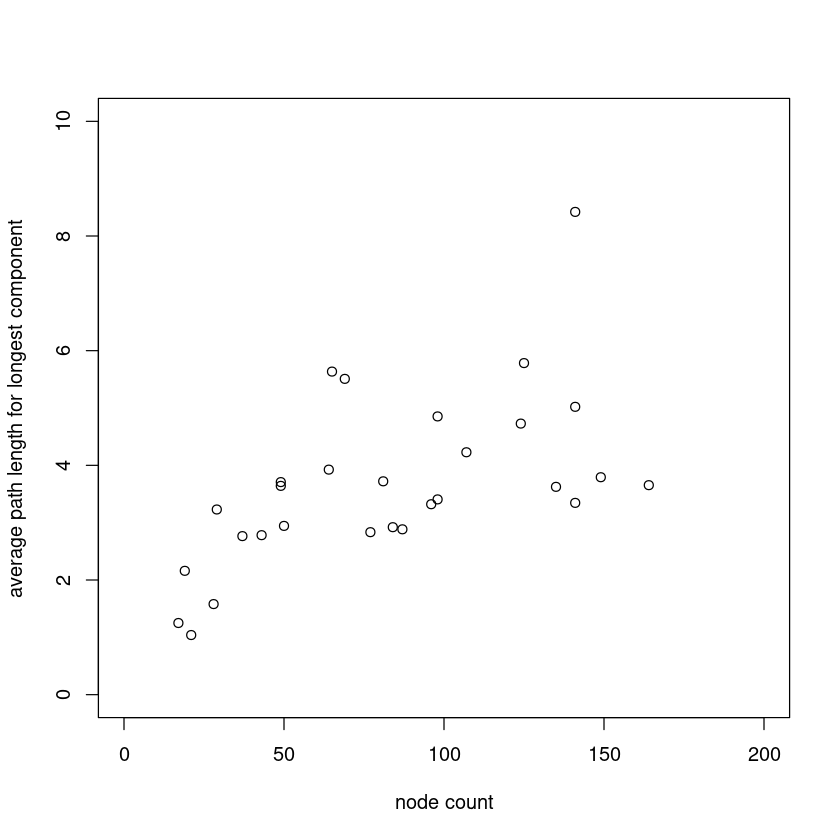

In [4]:
plot(data$nodes,
     data$avg_path_length_lc,
     xlab="node count",
     ylab="average path length for longest component",
     xlim=c(0,200),
     ylim=c(0,10));

We might also like to see the Pearson Correation Coefficient and the level of confidence that we can have, given a default confidence level of $0.95$.

In [5]:
result <- cor.test(data$nodes, data$avg_path_length_lc);
print("Coefficient:")
result$estimate
print("p-value:")
result$p.value

[1] "Coefficient:"


cor 
0.5104153

[1] "p-value:"


[1] 0.002838382

Given the confidence level of $0.95$, then we apply $ \alpha = 0.05 $. Since the p-value is lower than the $ \alpha $ then this result is statistically significant. Note that this interpretation relies on their being a good sample without sampling errors.

\
\.

Regarding the networks in this analysis: each edge represents a direct contact between one vole and another. If the shortest path between two voles has more than one edge then those two voles have no direct contact.

The strong correlation between network size and average path length suggests that as a population of voles grows then each vole doesn't come into contact with every other. This could be because these animals are territorial or limit their contact with others of their species for some other survival reason. 

### Appendix

#### My code

Dumped here but not exectuted

In [ ]:
# my_functions.R

getAdjMatrix = function(filePath) {
    adjTable = read.table(file = filePath, header = FALSE);
    adjMatrix = as.matrix(adjTable);
    (adjMatrix);
}

# I tried for a while to display network graphs on a grid in R. 
# It ended up introducing complexity. It was easier to save 
# them to files and then combine them using a bash script.
# See the bash scipt makeGrid.sh
plotAllNetworks = function(networks) {
    networkVizFolder = "networkViz";
    for (i in 1:length(networks)) {
        fileName = sprintf("chart%s.png", i);
        filePath = sprintf("%s/%s",networkVizFolder, fileName);
        title = sprintf("gvole net %s", i);
        png(filePath);
        plot(networks[[i]], main=title);
        dev.off();
    }
}

collectIndices = function(uncollectedIndices, searchResult) {
    componentIndices = c();
    otherIndices = c();
    for (i in uncollectedIndices) {
        if (searchResult[[i]] == -1) {
            otherIndices = c(otherIndices, i);
        } else {
            componentIndices = c(componentIndices, i);
        }
    }
    (list(component=componentIndices, other=otherIndices));
}

# This seemed simpler, in the end, compared to using igraph.
partitionIndicesByComponent = function(network) {
    components = list();
    comp_i = 1;
    
    i = 1;
    searchResult = levels(network, i);
    nodeIndices = 1:length(searchResult); # These are assigned once
    
    indices = collectIndices(nodeIndices, searchResult);
    componentIndices = indices$component;
    components[[comp_i]] = componentIndices;
    uncollectedIndices = indices$other;
    
    while (length(uncollectedIndices) > 0) {
        i = uncollectedIndices[1];
        searchResult = levels(network, i);
        
        indices = collectIndices(uncollectedIndices, searchResult);
        componentIndices = indices$component;
        
        comp_i = comp_i + 1;
        components[[comp_i]] = componentIndices;
        uncollectedIndices = indices$other;
    }
    (components)
}

getLCIndices = function(components) {
    largest_i = 1;
    largestNumberOfPaths = 0;
    for (i in 1:length(components)) {
        component = components[[i]];
        if (length(component) > largestNumberOfPaths) {
            largestNumberOfPaths = length(component);
            largest_i = i;
        }
    }
    (components[[largest_i]])
}

chompMinus1 = function(vector) {
    chompedVector = c();
    for (i in 1:length(vector)) {
        if (vector[[i]] != -1) {
            chompedVector = c(chompedVector, vector[[i]]);
        }
    }
    (chompedVector)
}

getLCPathMatrix = function(LCIndices, network, n) {
    numberOfIndices = length(LCIndices);
    pathMatrix = matrix(, nrow=numberOfIndices, ncol=0);
    for (i in LCIndices) {
        pathLengths = levels(network, i);
        pathLengths = chompMinus1(pathLengths);
        pathMatrix = cbind(pathMatrix, pathLengths);
    }
    (pathMatrix)
}

getDataForNetwork = function(network, dataForAllNetworks) {
    # Let LC be largest component
    n = network.size(network);
    e = network.edgecount(network);
    indicesByComponent = partitionIndicesByComponent(network);
    numberOfComponents = length(indicesByComponent);
    LCIndices = getLCIndices(indicesByComponent);
    LCPathMatrix = getLCPathMatrix(LCIndices, network, n);
    numberOfNodesInLC = length(LCIndices);
    fractionOfNodesInLC = numberOfNodesInLC/n;
    averageDegree = mean(degree(network, gmode="graph"));
    averagePathLengthForLC = mean(LCPathMatrix);
    
    dataForNetwork = list(net_id=get.network.attribute(network, "net id"),
                          nodes=n,
                          edges=e,
                          components=numberOfComponents,
                          lc_node_share=fractionOfNodesInLC,
                          avg_degree=averageDegree, 
                          avg_path_length_lc=averagePathLengthForLC );
    
    (dataForNetwork)
}

getDataForAllNetworks = function(networks) {
    dataForAllNetworks = data.frame(net_id = integer(),
                                    nodes = integer(),
                                    edges = integer(),
                                    comonents = integer(),
                                    lc_node_share = numeric(),
                                    avg_degree = numeric(),
                                    avg_path_length_lc = numeric()
                                   );

    for (i in 1:length(networks)) {
        dataForOneNetwork = getDataForNetwork(networks[[i]]);
        dataForAllNetworks = rbind(dataForOneNetwork,dataForAllNetworks);
    }
    (dataForAllNetworks[order(dataForAllNetworks$net_id),])
}



.

In [ ]:
# tests.R

#################################
### Test collectIndices

nodeIndices = 1:7
searchResult = c(-1,2,1,2,-1,-1,1)

result = collectIndices(nodeIndices, searchResult)

assert(as.vector(result$other) == c(1,5,6))
assert(as.vector(result$component) == c(2,3,4,7))

#################################
### Test partitionIndicesByComponent sparse network

adjMatrix = matrix(c(0,1,0,0,0,0,1,
         1,0,0,0,0,0,0,
         0,0,0,1,0,0,0,
         0,0,1,0,1,0,0,
         0,0,0,1,0,0,0,
         0,0,0,0,0,0,0,
         1,0,0,0,0,0,0), 
           nrow=7,
           ncol=7)

network <- as.network.matrix(adjMatrix, matrix.type="adjacency", directed=FALSE)

result = partitionIndicesByComponent(network)

assert(result[[1]] == c(1,2,7))
assert(result[[2]] == c(3,4,5))
assert(result[[3]] == c(6))

#################################
### Test getLCPathLengths

components = list()
components[[1]] = c(5,4,3,2,1)
components[[2]] = c(1)
components[[3]] = c(3,2,1)

result = getLCIndices(components)

assert(result == c(5,4,3,2,1))

#################################
### Test chompMinus1

vector = c(-1,-1,1,0,2,-1,1,3)

result = chompMinus1(vector);
assert(result == c(1,0,2,1,3));

#################################
### Test getLCPathMatrix 

adjMatrix = matrix(c(0,1,0,0,0,0,1,
         1,0,0,0,0,0,0,
         0,0,0,1,1,0,0,
         0,0,1,0,1,0,0,
         0,0,1,1,0,0,0,
         0,0,0,0,0,0,0,
         1,0,0,0,0,0,0), 
           nrow=7,
           ncol=7)

network <- as.network.matrix(adjMatrix, matrix.type="adjacency", directed=FALSE);

LCIndices = c(3,4,5)

result = getLCPathMatrix(LCIndices, network, 7)

expected = matrix(c(0,1,1,
        1,0,1,
        1,1,0), 
           nrow=3,
           ncol=3);

assert(result == expected);

#################################
print("Tests pass")

.

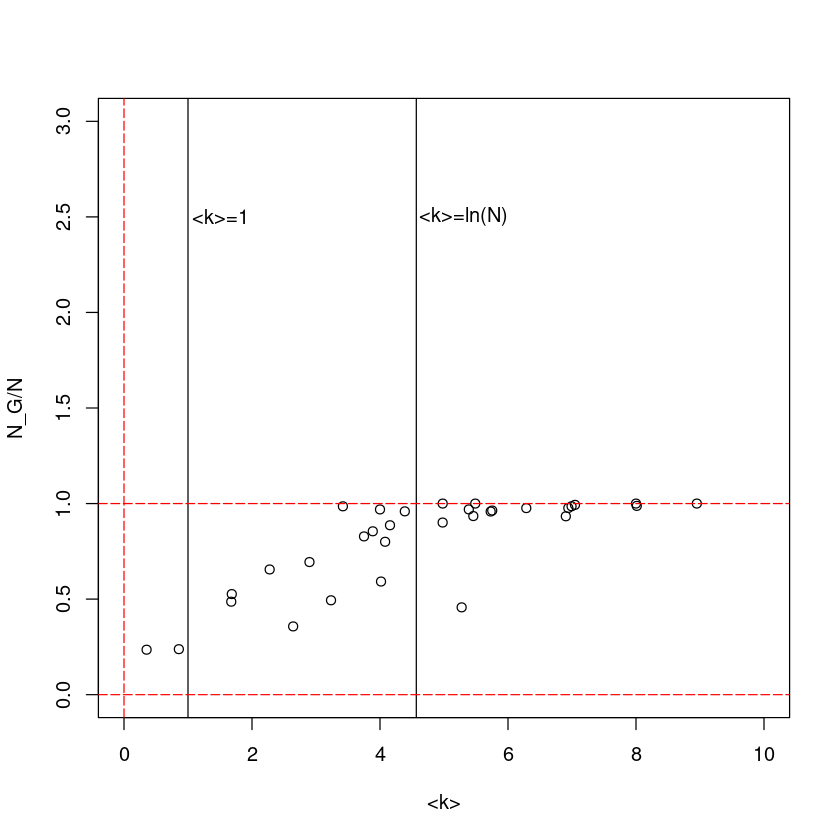

In [43]:
plot(data$avg_degree,
     data$lc_node_share,
     xlab="<k>",
     ylab="N_G/N",
     xlim=c(0,10),
     ylim=c(0,3));

avg_nodes = mean(data$nodes);

abline(v=1);
abline(v=log(avg_nodes));
text(x=1.5, y=2.5, '<k>=1');
text(x=5.3, y=2.5, '<k>=ln(N)');

abline(v=0, col="red", lty=5);
abline(h=0, col="red", lty=5);
abline(h=1, col="red", lty=5);

In [33]:
log(10)

[1] 2.302585